# Yolo v3 en Keras parte 2

In [1]:
! cp /content/drive/MyDrive/clases/"Computer Vision Modulo 1"/"Clase 8"/yolov3.h5 ./yolov3.h5

In [6]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf

In [4]:
yolov3 = load_model('./yolov3.h5')

## Bounding Boxs

In [103]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
    self.xmin = xmin
    self.xmax = xmax
    self.ymax = ymax
    self.ymin = ymin
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label_score(self):
    self.label = np.argmax(self.classes)
    self.score = self.classes[self.label]
    return self.label, self.score

def decode_anchors(netout_o, anchors, imgh, imgw, obj_thresh):
  netout = netout_o.copy()
  boxes = []
  grid_h, grid_w = netout.shape[:2]
  n_box = 3
  filters_out = (5+80)
  netout = netout.reshape((grid_h, grid_w, n_box,filters_out))
  netout[...,:2] = tf.sigmoid(netout[...,:2]).numpy()
  netout[...,4:] = tf.sigmoid(netout[...,4:]).numpy()
  netout[...,5:] = netout[...,4][...,np.newaxis]*netout[...,5:]# Tenemos las probabilidades de cada clase
  netout[...,5:] *= netout[...,5:] > obj_thresh # Aplicamos umbral
  print(netout[...,5:][netout[...,5:]>obj_thresh])
  for i in range(grid_h):
    for k in range(grid_w):
      for b in range(n_box):
        objectness = netout[i][k][b][4]
        if(objectness <= obj_thresh): continue
        tx, ty, tw, th = netout[i][k][b][:4]
        x = (tx + k) / grid_w
        y = (ty + i) / grid_h
        w = anchors[2*b + 0] * np.exp(tw) / imgw
        h = anchors[2*b + 1] * np.exp(th) / imgh
        classes = netout[i][k][b][5:]
        box = BoundBox(x-w/2,y-h/2,x+w/2,y+h/2, objectness, classes)
        box.get_label_score()
        boxes.append(box)
  return boxes

Prueba 1, sobre una imagen

In [12]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [15]:
img = load_img('dogs3.jpg',target_size=(416,416))
img = np.array(img)

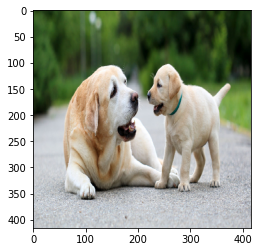

In [16]:
plt.imshow(img)
plt.show()

In [104]:
netout = yolov3.predict(img.reshape((-1,416,416,3)))

In [112]:
netout[0].shape

(1, 13, 13, 255)

In [31]:
netout[0][0][5][5][:25]

array([ 0.6224593,  0.6750375, -4.2231407, -0.7008199,  0.6224593,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
      dtype=float32)

In [119]:
anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]
BOXES = []
for k in range(1):
  NETOUT = netout[k][0]
  boxes = decode_anchors(NETOUT, anchors[6*k:6*(k+1)], 416, 416, 0.0)
  try:
    BOXES.extend(boxes)
  except:
    continue

[1.0019156e-12 2.1105171e-15 1.8656654e-12 ... 3.0281121e-25 4.1629476e-27
 8.0063126e-27]


In [120]:
len(BOXES)

267

In [121]:
BOXES[0].objness

1.5957055e-07

In [123]:
BOXES[100].score

7.907481e-39